In [1]:
import numpy as np
import cv2
import mediapipe as mp
import os
import pandas as pd
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from time import perf_counter_ns
import sqlite3
import json
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

from functions_ml import refactor_video_into_input, load_mp_image, extract_keypoints

In [3]:
mp_holistic = mp.solutions.holistic

In [4]:
pose_conn = set(conn for conn in mp_holistic.POSE_CONNECTIONS if all(idx in range(11, 23) for idx in conn))
pose_conn

{(11, 12),
 (11, 13),
 (12, 14),
 (13, 15),
 (14, 16),
 (15, 17),
 (15, 19),
 (15, 21),
 (16, 18),
 (16, 20),
 (16, 22),
 (17, 19),
 (18, 20)}

In [50]:
IMAGE_SIZE = (256, 256)
SEQUENCE_LENGTH = 25
POSE_START_INDEX = 11
POSE_END_INDEX = 25

IMG_DIR = 'test_img'
RECORDINGS_DIR = 'test_video'
LOADED_VIDEOS_DIR = 'loaded_videos'
IMG_PROCESS = True

TESTING_IMG = "rotated.png"
TESTING_VIDEO = "rotated.webm"

DB_NAME = 'slr.db'
TABLE_NAME = 'sign_videos'

DETECTOR_MODEL_NAME = 'pose_landmarker_full.task'

In [51]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\Computer-Vision-Sign-Language\\jupyter_notebooks'

In [52]:
with open(DETECTOR_MODEL_NAME, 'rb') as det_bytes_model:
    model_data = det_bytes_model.read()

In [53]:
base_options = python.BaseOptions(model_asset_buffer=model_data)
running_mode = vision.RunningMode


detector_options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    running_mode=running_mode.VIDEO if not IMG_PROCESS else running_mode.IMAGE)


In [78]:
imgs = [os.path.join(IMG_DIR, i) for i in ['right.png', 'left.png']]

In [82]:
kps = []

with vision.PoseLandmarker.create_from_options(detector_options) as key_points_detector:
    for img in imgs:

        img = Image.open(img)

        results = key_points_detector.detect(load_mp_image(np.array(img)))
        kp = extract_keypoints(results, pose_indexes=(0, 33), use_visibility=True)

        kps.append(kp)

In [88]:
kps[0][15:17]

array([[ 0.92053044,  0.00190651, -0.54756713,  0.99277484],
       [ 0.58633804,  0.42914516, -1.23363721,  0.96096021]])

In [89]:
kps[1][15:17]

array([[ 0.58548117,  1.20050561, -0.79236162,  0.88080853],
       [ 0.14014798,  0.37543339, -0.24050677,  0.96880084]])

: 

In [34]:
video_path = os.path.join(RECORDINGS_DIR, TESTING_VIDEO)
img_path = os.path.join(IMG_DIR, TESTING_IMG)

In [35]:
img_org = Image.open(img_path)
img_array = np.array(img_org)

### Get keypoints for video

In [41]:
videos = [os.path.join(RECORDINGS_DIR, v) for v in [
    'right_hello.webm',
    'left_hello.webm'
]]

In [42]:
compare_results = []

for v in videos:

    video_keypoints = refactor_video_into_input(
        video_path=v,
        detector_options=detector_options,
        sequence_length=SEQUENCE_LENGTH,
        pose_indexes=(POSE_START_INDEX, POSE_END_INDEX),
        image_size=IMAGE_SIZE,
        video_task=True,
        use_visibility=False
    )

    compare_results.append(video_keypoints)

In [44]:
right_hello, left_hello = compare_results[0], compare_results[1]

In [30]:
YZ_reflection = np.eye(4)
YZ_reflection[0, 0] = -1
YZ_reflection

array([[-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [47]:
right_hello[1]

array([[0.5913 , 0.45   , 0.617  ],
       [0.3694 , 0.4348 , 0.313  ],
       [0.6533 , 0.552  , 0.64   ],
       [0.542  , 0.4973 , 0.1104 ],
       [0.5723 , 0.4824 , 0.5996 ],
       [0.653  , 0.3044 , 0.07886],
       [0.5513 , 0.4736 , 0.585  ],
       [0.7256 , 0.2727 , 0.05063],
       [0.534  , 0.4565 , 0.597  ],
       [0.6763 , 0.2517 , 0.0532 ],
       [0.5376 , 0.4626 , 0.6    ],
       [0.6787 , 0.2852 , 0.07996],
       [0.561  , 0.8306 , 0.5723 ],
       [0.3748 , 0.8345 , 0.4285 ]], dtype=float16)

In [48]:
left_hello[1]

array([[0.715 , 0.4153, 0.2128],
       [0.4448, 0.4429, 0.737 ],
       [0.7173, 0.681 , 0.1532],
       [0.2113, 0.495 , 0.7593],
       [0.665 , 0.904 , 0.2391],
       [0.3354, 0.2878, 0.668 ],
       [0.669 , 0.968 , 0.2002],
       [0.366 , 0.2334, 0.6406],
       [0.634 , 0.9644, 0.1895],
       [0.3926, 0.2341, 0.668 ],
       [0.628 , 0.9424, 0.2355],
       [0.3938, 0.2542, 0.6636],
       [0.681 , 0.913 , 0.3335],
       [0.4634, 0.9053, 0.668 ]], dtype=float16)

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to plot a graph using NetworkX with normalized coordinates
def get_kp_graph(
        connections: list[tuple[int, int]],
        coordinates: list[tuple[float, float]],
        start_kp_index: int = 11):
    
    G = nx.Graph()

    for node, (x, y) in enumerate(coordinates, start=start_kp_index):
        G.add_node(node, pos=(x, 1 - y))

    G.add_edges_from(connections)
    pos = nx.get_node_attributes(G, 'pos')

    return G, pos

### Get keypoints for rotated image

In [163]:
translation_vec = np.array([-0.5, 0, -0.5])
theta = np.radians(-20.5)

rotation_matrix = np.array([[np.cos(theta), 0, -np.sin(theta)],
                            [0, 1, 0],
                            [np.sin(theta), 0, np.cos(theta)]])

In [164]:
res = ((rotation_matrix @ (t.reshape(-1, 3) + translation_vec).T).T - translation_vec).reshape(t.shape[0], 25, -1, 3)

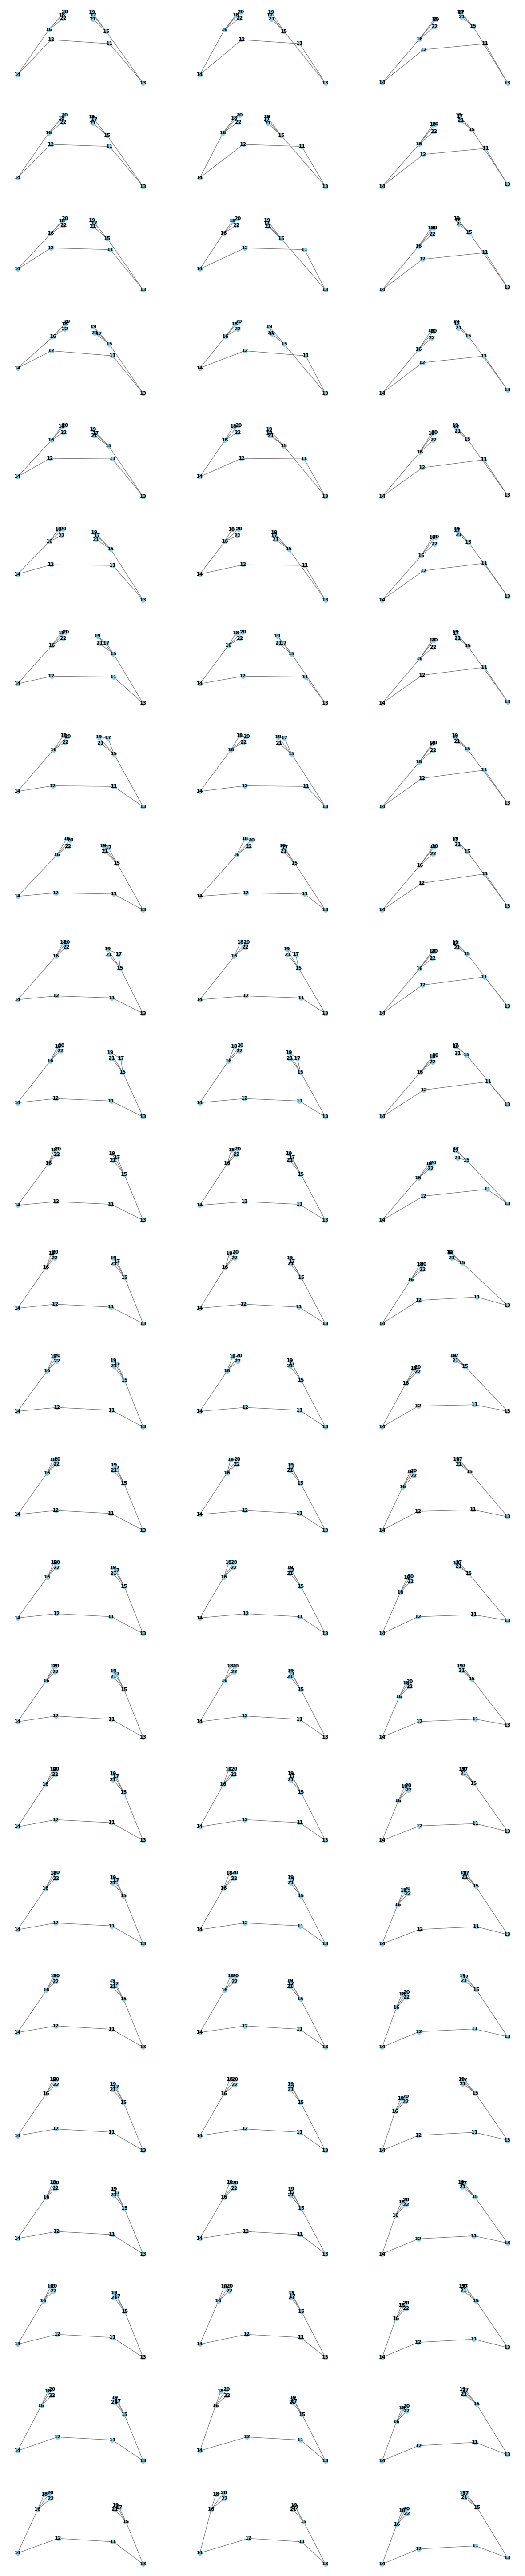

In [162]:
fig, ax = plt.subplots(t.shape[1], 3, figsize=(15, 3 * t.shape[1]))

for step, (org_cords, org_rot) in enumerate(zip(t[0], t[1])):

    rotated_cords = (rotation_matrix @ (org_cords + translation_vec).T).T - translation_vec

    G_org, pos_org = get_kp_graph(
        connections=pose_conn, 
        coordinates=org_cords[:-2, :2]
    )

    G_org_rot, pos_org_rot = get_kp_graph(
        connections=pose_conn, 
        coordinates=org_rot[:-2, :2]
    )

    G_rot, pos_rot = get_kp_graph(
        connections=pose_conn, 
        coordinates=rotated_cords[:-2, :2]
    )

    for i, (graph, positions) in enumerate([(G_org, pos_org), (G_rot, pos_rot), (G_org_rot, pos_org_rot)]): 

        nx.draw(
            graph, 
            positions, 
            with_labels=True, 
            font_weight='bold', 
            node_size=50, 
            node_color='skyblue', 
            font_color='black', 
            font_size=8, 
            edge_color='gray', 
            ax=ax[step, i]
        )

plt.show()

In [10]:
key_points_detector = vision.PoseLandmarker.create_from_options(detector_options)

In [11]:
raw_keypoints_org = key_points_detector.detect(load_mp_image(img_array, img_size=IMAGE_SIZE))
keypoints_org = extract_keypoints(raw_keypoints_org, (POSE_START_INDEX, 25), use_visibility=True)

In [12]:
keypoints_org

array([[ 0.63984191,  0.67728102,  0.16663639,  0.99880183],
       [ 0.29102004,  0.62802714, -0.41562843,  0.99981779],
       [ 0.61748421,  0.97872519,  0.3349869 ,  0.15563557],
       [ 0.20510574,  1.00028992, -0.95223743,  0.94781977],
       [ 0.67079896,  1.19303799,  0.11466662,  0.04571178],
       [ 0.48413152,  0.95836228, -1.65744174,  0.88448203],
       [ 0.69628805,  1.2634877 ,  0.08087029,  0.06447355],
       [ 0.57607353,  0.92132217, -1.79851139,  0.82206762],
       [ 0.69330871,  1.25048399,  0.00617765,  0.07908329],
       [ 0.55716556,  0.86352926, -1.75461602,  0.82399696],
       [ 0.67396277,  1.22461617,  0.07121447,  0.09187621],
       [ 0.52604467,  0.87127405, -1.6463753 ,  0.8153218 ],
       [ 0.60694462,  1.30973303,  0.13027957,  0.08192684],
       [ 0.32171622,  1.33297169, -0.12698317,  0.12139736]])

In [128]:
max_val = np.max(np.fabs(keypoints_org[:, 2]))
keypoints_org[:, 2] = (keypoints_org[:, 2] + max_val) / (max_val * 2)

### We can perform rotation on keypoints using rotation matrix around Y axis

In [50]:
translation_vec = np.array([-0.5, 0, -0.5])
theta = np.radians(90)

In [51]:
rotation_matrix = np.array([[np.cos(theta), 0, -np.sin(theta)],
                            [0, 1, 0],
                            [np.sin(theta), 0, np.cos(theta)]])


In [52]:
rotated_keypoints = (rotation_matrix @ (t[0][5] + translation_vec).T).T - translation_vec

In [91]:
translation_vec_2 = np.array([-0.5, 0, 1])
theta2 = np.radians(-45)

In [92]:
rotation_matrix_2 = np.array([[np.cos(theta2), 0, -np.sin(theta2)],
                            [0, 1, 0],
                            [np.sin(theta2), 0, np.cos(theta2)]])

In [93]:
P = np.array([
    [0, 0, 0],
    [0.5, 0, 0],
    [1, 0, 0],
    [0.5, 0, 0.5],
])

In [97]:
P_prim = P + translation_vec_2
P_prim

array([[-0.5,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       [ 0.5,  0. ,  1. ],
       [ 0. ,  0. ,  1.5]])

In [98]:
(rotation_matrix_2 @ P_prim.T).T

array([[0.35355339, 0.        , 1.06066017],
       [0.70710678, 0.        , 0.70710678],
       [1.06066017, 0.        , 0.35355339],
       [1.06066017, 0.        , 1.06066017]])

In [74]:
test2

array([ 1.20710678,  0.        , -0.29289322])

### Now we need to check whether rotating the image and extracting the keypoints give the same results

In [111]:
img_array = cv2.resize(img_array, IMAGE_SIZE)

In [112]:
rotation_angle = 135
rotY = (rotation_angle - 90) * np.pi / 180

In [113]:
RY_44 = np.matrix([
    [ np.cos(rotY), 0, np.sin(rotY), 0],
    [            0, 1,            0, 0],
    [ -np.sin(rotY), 0, np.cos(rotY), 0],
    [            0, 0,            0, 1]
])

In [114]:
dist = 500
f = 500
h, w = img_array.shape[:2]
dst = np.ndarray(shape=img_array.shape, dtype=img_array.dtype)

#### Projection 2D -> 3D matrix

In [115]:
A1 = np.matrix([
    [1, 0, -w/2],
    [0, 1, -h/2],
    [0, 0, 0   ],
    [0, 0, 1   ]
])

#### Camera Intrisecs matrix 3D -> 2D

In [116]:
A2 = np.matrix([
    [f, 0, w/2 ,0],
    [0, f, h/2, 0],
    [0, 0,   1, 0]
])

#### Translation matrix on the Z axis change dist will change the height

In [117]:
T = np.matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dist],
    [0, 0 , 0, 1]
])

#### Final and overall transformation matrix

In [118]:
H = A2 * (T * (RY_44 * A1))

In [119]:
rotated_img = cv2.warpPerspective(img_array, H, (w, h), dst, cv2.INTER_CUBIC)

### Rotated image

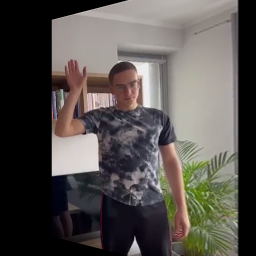

In [120]:
Image.fromarray(rotated_img)

In [121]:
raw_keypoints_rotated = key_points_detector.detect(load_mp_image(rotated_img, img_size=IMAGE_SIZE))
keypoints_rotated_img = extract_keypoints(raw_keypoints_rotated, (POSE_START_INDEX, 25), use_visibility=False)

In [122]:
keypoints_rotated_img[:, 2] = (keypoints_rotated_img[:, 2] + max_val) / (max_val * 2)

In [123]:
keypoints_rotated_img

array([[0.61985594, 0.46370542, 0.40368611],
       [0.39245322, 0.46179482, 0.41737006],
       [0.6759131 , 0.65286154, 0.45291583],
       [0.23914689, 0.50549436, 0.29659815],
       [0.71107894, 0.84081143, 0.46834496],
       [0.30101234, 0.34156653, 0.16445006],
       [0.72247571, 0.8971113 , 0.46466305],
       [0.28806496, 0.29243201, 0.13775823],
       [0.70276421, 0.89433515, 0.44975535],
       [0.3027983 , 0.28991887, 0.15732505],
       [0.69576603, 0.88007379, 0.46393945],
       [0.31668684, 0.31003764, 0.16831423],
       [0.58782506, 0.79959488, 0.49588897],
       [0.46069551, 0.80234259, 0.50405871]])

#### Single point in time is represented by $12$ points each of $3$ cordinates $x, y, z$

In [ ]:
if not os.path.exists(video_path):
    print(f"Path: {video_path} does not exist")

print(f"Processing: {video_path}")

keypoints, key_diff = refactor_video_into_input(
    video_path=video_path,
    use_visibility=False,
    pose_indexes=(POSE_START_INDEX, POSE_END_INDEX),
    video_task=True,
    detector_options=detector_options,
)

# except Exception as e:

#     print(f"For {video_path} error occured: {e}")

### Examined video
<video width="256" height="256" controls>
    <source src="test_video/hello_video_7.mp4" type="video/mp4">
</video>